# Installing the required packages and moving them to the input folder  

In [1]:
!pip install yachalk --target=/kaggle/working/python-pkgs/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 14.5 MB/s eta 0:00:00a 0:00:01


In [6]:

%pip install "unstructured[pdf]" --user
!mv /root/.local/lib/python3.x/site-packages/unstructured /kaggle/working/python-pkgs/
%pip install langchain --target=/kaggle/working/python-pkgs/
%pip install unstructured  
!mv /root/.local/lib/python3.x/site-packages/unstructured /kaggle/working/python-pkgs/
#%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.

In [8]:
import shutil

# Replace 'output_filename' and 'dir_name' with your desired values
output_filename = 'python-pkgs'
dir_name = '/kaggle/working/python-pkgs/'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', dir_name)


'/kaggle/working/python-pkgs.zip'

In [10]:
from IPython.display import FileLink
FileLink(r'python-pkgs.zip')

/kaggle/working/python-pkgs.zip

# Importing libraries

In [1]:
import sys
sys.path.append('/kaggle/input/site-packages/') # Pass the path where the installed packages are uploaded
import os
os.getcwd()
import pandas as pd
import numpy as np
import os
import random
import re
import unicodedata
from langchain.document_loaders import PyPDFLoader, UnstructuredPDFLoader, PyPDFium2Loader
from langchain.document_loaders import PyPDFDirectoryLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pathlib import Path
import itertools


In [2]:
sys.path.append('/kaggle/input/check-utility/') #sys.path.insert(1,''/kaggle/input/site-packages/'/prompt_gen.py')
from prompt_gen import graphPrompt

/kaggle/working
updated


In [6]:
#sys.path.append('/kaggle/input/ollama-call/') #sys.path.insert(1,''/kaggle/input/site-packages/'/prompt_gen.py')
%run /kaggle/input/d/vidyarao1310/ollama-call-6/ollama_call_v2.py #i future edit this 


FileNotFoundError: [Errno 2] No such file or directory: '!pip'

In [5]:
graphPrompt("substance is burnt in pure dioxygen supplied in the steel bomb. heat evolved during the reaction is transferred to the water around the bomb and ", {"chunk_id": "chunk_id"}, "zephyr")

An error occurred: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/chat (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7d1ab2ba5780>: Failed to establish a new connection: [Errno 111] Connection refused'))
{'chunk_id': 'chunk_id'}


ERROR ### Here is the buggy response:  None 




In [4]:
import logging

# Set the logging level for requests (and urllib3 if needed)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)


In [29]:
## Input data directory
data_dir = "/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths"#/iemh111.pdf" #"CBSE_TextBook_pdf"
inputdirectory = Path(f"{data_dir}")

In [12]:
## This is where the output csv files will be written
out_dir = "data_output_7_April"
outputdirectory = Path(f"./{out_dir}")

In [13]:
os.getcwd()

'/kaggle/working'

In [ ]:
os.listdir()
os.chdir('./Codes/')

# Helper function transfer to another script

In [56]:


#Derived from the client and prompts script of **rahulnyk/knowledge_graph**, with my own modifications.

import sys
from yachalk import chalk
import os
print(os.getcwd())
import json
import os
import requests
print("updated")

# %% [code]
def generate( model_name=None,prompt=None, system=None, template=None, context=None, options=None, callback=None):
    try:
        url = f"{'http://localhost:11434/api/chat'}"#"/api/generate"
      
        payload = {
            "model": "zephyr",
            "temperature": 0.6,# value of 0.6 strikes a balance between creativity and coherence.
            "stream": False,
            "messages": [
                {"role": "system", "content":system},
                {"role": "user", "content": prompt}
            ]
        }

        
        # Remove keys with None values
      #  payload = {k: v for k, v in payload.items() if v is not None}
        
        with requests.post(url, json=payload, stream=True) as response:
            response.raise_for_status()
            
            # Creating a variable to hold the context history of the final chunk
            final_context = None
            
            # Variable to hold concatenated response strings if no callback is provided
            full_response = ""

            # Iterating over the response line by line and displaying the details
            for line in response.iter_lines():
                if line:
                    # Parsing each line (JSON chunk) and extracting the details
                    chunk = json.loads(line)
                    if callback:
                        callback(chunk)
                    else:
                        # If this is not the last chunk, add the "response" field value to full_response and print it
                        if  chunk.get("done"):
                            response_piece = chunk.get("message")['content']
                            full_response += response_piece
                          #  print(response_piece, end="", flush=True)
                    
                    # Check if it's the last chunk (done is true)
                    if chunk.get("done"):
                        final_context = chunk.get("context")
            
            # Return the full response and the final context
            return full_response, final_context
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None, None



def graphPrompt(input: str, metadata={}, model="mistral-openorca:latest"):
    if model == None:
        model = "zephyr"#"mistral-openorca:latest"

    SYS_PROMPT = (
    "You are a network graph maker who extracts terms and their relations from "
    "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
    "of necessary key scientific and mathematical concepts mentioned in the given context.\n"
    "Thought 1: While traversing through each sentence, please list terms including entities, concepts, and topics within physics, math, and chemistry.\n "
        "\tTerms can be fundamental principles, laws, equations, constants, theories, formulas,theorems, elements, compounds, reactions, etc..\n"
        "\tTerms should be as atomistic as possible.\n\n"
    "Thought 2: let's determine the relationships between the identified entities within and across the domains.\n"
         "\tThink about dependencies, causal relationships, hierarchical relationships,mathematical relationships.\n"
         "\tFind relationship between terms leveraging semantic relationships such as 'is-a,' 'part-of,''derives-from,' 'is-related-to,' etc., to capture the semantics between different entities. \n\n"
    "Thought 3:Format your output as a list of json. Each element of the list contains a pair of terms,\n"
    "and the relation between them, like the follwing: \n"      
    "[\n"
    "   {\n"
    '       "concept_1": "A concept from extracted ontology",\n'
    '       "concept_2": "A related concept from extracted ontology",\n'
    '       "description": "relationship between the two concepts, concept_1 and concept_2 in one or two lines but keep it concise."\n'
    '       "edge":"semantic relationship between concepts such as is-a, part-of,derives-from,is-related-to, etc.,",\n'
          
    "   }, {...}\n"
    "]"
     )
         
    
    USER_PROMPT = f"context: ```{input}``` \n\n output: "
    response, _ = generate(model_name=model, system=SYS_PROMPT, prompt=USER_PROMPT)
    try:
          print(metadata)
          result = json.loads(response)
          result = [dict(item, **metadata) for item in result]
    except:
        print("\n\nERROR ### Here is the buggy response: ", response, "\n\n")
        result = None
    return result


/kaggle/working
updated


In [125]:
    SYS_PROMPT = (
    "You are a network graph maker who extracts terms and their relations from "
    "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
    "of necessary key scientific and mathematical concepts mentioned in the given context.\n"
    "Thought 1: While traversing through each sentence, please list terms including entities, concepts, and topics within physics, math, and chemistry.\n "
        "\tTerms can be fundamental principles, laws, equations, constants, theories, formulas,theorems, elements, compounds, reactions, etc..\n"
        "\tTerms should be as atomistic as possible.\n\n"
    "Thought 2: let's determine the relationships between the identified entities within and across the domains.\n"
         "\tThink about dependencies, causal relationships, hierarchical relationships,mathematical relationships.\n"
         "\tFind relationship between terms leveraging semantic relationships such as 'is-a,' 'part-of,''derives-from,' 'is-related-to,' etc., to capture the semantics between different entities. \n\n"
    "Thought 3:Format your output as a list of json. Each element of the list contains a pair of terms,\n"
    "and the semantic relation between them and description, like the follwing: \n"      
    "[\n"
    "   {\n"
    '       "concept_1": "A concept from extracted ontology",\n'
    '       "concept_2": "A related concept from extracted ontology",\n'
    '        "edge":"semantic relationship",\n'
    '       "description": "relationship between the two concepts, concept_1 and concept_2 in one or two lines but keep it concise."\n'
    "   }, {...}\n"
    "]"
     )
    

# Load pdf files from the destined folder

RecursiveCharacterTextSplitter

By default the characters it tries to split on are [“\n\n”, “\n”, “ “, “”]
length_function:length of chunks is calculated. Defaults to just counting number of characters, but it’s pretty common to pass a token counter here.

- chunk_size: the maximum size of your chunks(as measured by the length function).

- chunk_overlap: the maximum overlap between chunks. (e.g. do a sliding window).

In [ ]:
## Dir PDF Loader
# loader = PyPDFDirectoryLoader(inputdirectory)
## File Loader
# loader = PyPDFLoader("./data/MedicalDocuments/orf-path_health-n1.pdf")
loader = DirectoryLoader(inputdirectory, show_progress=True)
documents = loader.load()
exclude_pattern = r"(Example \d+:|Exercise \d+\.\d+)"
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,# chunk size of the text extracted from the pdf
    chunk_overlap=100,# The overlap length while extraction
    length_function=len,
    is_separator_regex=False,
   # separator_pattern=exclude_pattern,
)

pages = splitter.split_documents(documents)
print("Number of chunks = ", len(pages))

print(pages[3].page_content)


## Create a dataframe of all the chunks

In [ ]:
import uuid
rows = []
for chunk in pages:
        row = {
            "text": chunk.page_content,
            **chunk.metadata,
            "chunk_id": uuid.uuid4().hex,
        }
        rows = rows + [row]

df = pd.DataFrame(rows)
df.head()
df["source"].unique()
df["source"][0].split("/")[-1]

In [ ]:
df.to_pickle("/kaggle/working/9_math.pkl") #store the dataframe in the pickle format

In [ ]:
os.getcwd()

# Clean the text corpus (shift it to utility)

In [ ]:
sys.path.append('/kaggle/input/check-utility/') #sys.path.insert(1,''/kaggle/input/site-packages/'/prompt_gen.py')
from txt_processing import rm_q_exam,clean_text,count_stopwords,count_numbers_in_text,tokenize_text,clean_elem

In [15]:
## Reading stored pkl file
df = pd.read_pickle(r'/kaggle/input/df-kl-sentences/my_data.pkl')
df.shape

(6953, 3)

Pre-processing to remove unnecessary topics
1. Removing the introduction and responses for exercise questions from the chunks 
2. Remove the questions detecting the wors indices through regex
3. Remove based on percentage of stop words in a sentence

In [16]:
df['flag_intro']=[1 if ("ps" ) in x.split("/")[-1] else  0 for x in df["source"]  ]
df['flag_ans']=[1 if ("an" ) in x.split("/")[-1] else  0 for x in df["source"]  ]
df.loc[df['flag_ans']==1,].shape #738 rows


(207, 5)

In [17]:
df=df.loc[df['flag_intro']!=1,] # filtering the dataframe
df=df.loc[df['flag_ans']!=1,]
df.shape

(6372, 5)

It is important to flag the Excercise in that line corresponding to the source.Extract till the miscallaneous for the math books between "EXERCISE" and "Miscellaneous" 

In [20]:
sources=df["source"].unique()
sources

array(['/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph206.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph203.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph204.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph201.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph205.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph202.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh105.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh1a2.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh101.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh112.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh104.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh110.pdf',
       '/kaggle/input/ncert-textbook/CBSE_Text

In [21]:
df_2=pd.DataFrame()
for k in sources:
    print(k)
    df_2=pd.concat([df_2,rm_q_exam(df,k)],ignore_index=True)
 


/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph206.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph203.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph204.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph201.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph205.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Physics_2/leph202.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh105.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh1a2.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh101.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh112.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh104.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh110.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh107.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/9_Maths/iemh111.pdf
/kaggle/input/ncert-textbook/CBS

/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["prev_text"]=temp["text"]
/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["prev_text"]=temp["text"]
/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh1a2.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh103.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh104.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh101.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh102.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh105.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_Maths/lemh1a1.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh1sp.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh104.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh113.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh109.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh114.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh106.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Maths/kemh101.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/1

/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["prev_text"]=temp["text"]
/tmp/ipykernel_34/2050772098.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["text"][index[i]]=text.split(pattern1)[0]
/tmp/ipykernel_34/2050772098.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["text"][index[i]]=text.split(pattern1)[0]
/tmp/ipykern

/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh113.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh112.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh110.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh107.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh102.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh111.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh106.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh109.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh104.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/8_Maths/hemh105.pdf
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech103.pdf
Nothing to process
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech105.pdf
Nothing to process
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech106.pdf
Nothing to process
/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech201.pdf
/kagg

/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["prev_text"]=temp["text"]
/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["prev_text"]=temp["text"]
/tmp/ipykernel_34/2050772098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [22]:
print(df_2.shape)
print(df_2.head())
chk=df_2.loc[df_2["text"].str.contains("EXERCISES")]
chk.shape

(6162, 6)
                                                text  \
0  Chapter Fourteen SEMICONDUCTOR ELECTRONICS: MA...   
1  14.1 INTRODUCTION Devices in which a controlle...   
2  Therefore, such devices are generally referred...   
3  Rationalised 2023-24\n\n324\n\nPhysics\n\nand ...   
4  In the following sections, we will introduce t...   

                                              source  \
0  /kaggle/input/ncert-textbook/CBSE_TextBook_pdf...   
1  /kaggle/input/ncert-textbook/CBSE_TextBook_pdf...   
2  /kaggle/input/ncert-textbook/CBSE_TextBook_pdf...   
3  /kaggle/input/ncert-textbook/CBSE_TextBook_pdf...   
4  /kaggle/input/ncert-textbook/CBSE_TextBook_pdf...   

                           chunk_id  flag_intro  flag_ans  \
0  6fb5a4f7d34a4ef1be1530069b783d58           0         0   
1  8c13887cc66f460286e65d858bcb1de3           0         0   
2  1291eb9a5ab348b9ab7d4e784a94b12d           0         0   
3  c6e311deed51437f80c63c0b879f4a47           0         0   
4  17c34ff5

(0, 6)

### Performing other activities including the - removal of extra spaces, special characters, percentage of stopword and numbers in a line

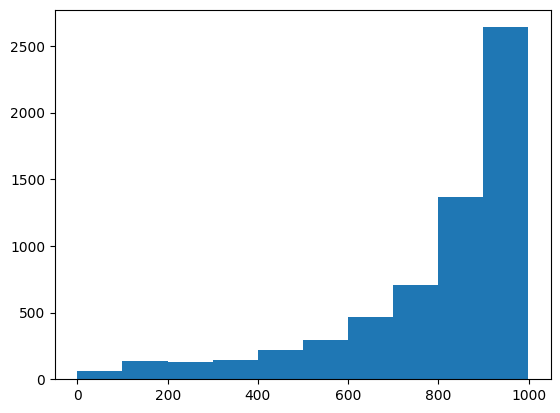

In [23]:
df_2["pr_text"]=df_2["text"].apply(clean_text)
aa=[len(x) for x in df_2["pr_text"]]
import matplotlib.pyplot as plt
plt.hist(aa)
df_2["char_cnt"]=aa
df_2["pr_text_tokens"]=df_2["pr_text"].apply(tokenize_text)
df_2["sw_percent"]=df_2["pr_text_tokens"].apply(count_stopwords)
df_2["num_percent"]=df_2["pr_text"].apply(count_numbers_in_text)


In [24]:
df_2["pr_text_tokens_sp_rm"]=df_2["pr_text_tokens"].apply(clean_elem)
def join_sentence(text):
        return   ' '.join(text)
df_2["pr_text_tokens_sp_rm_text"]=df_2["pr_text_tokens_sp_rm"].apply(join_sentence) #no lemmatisation not required

### Executing them kind of changes the meaning of the statements

In [59]:
    def clean_elem(tokens): # Also remove those elements whose length is equal to 1
        # Define a custom list of redundant stopwords

        #filtered_tokens = [token for token in tokens if token not in custom_stopwords]
        filtered_tokens=[token for token in tokens if len(token)>1]
        return filtered_tokens
df_2["pr_text_tokens_sp_rm"]=df_2["pr_text_tokens"].apply(clean_elem)

In [61]:
def join_sentence(text):
        return   ' '.join(text)
df_2["pr_text_tokens_sp_rm_text"]=df_2["pr_text_tokens_sp_rm"].apply(join_sentence) #no lemmatisation not required

### Filtering the dataframe

In [27]:
df_2['sw_percent'].quantile([0, 0.25, 0.5, 0.75, 1.0])

0.00     0.000000
0.25    21.223389
0.50    28.571429
0.75    34.077178
1.00    66.666667
Name: sw_percent, dtype: float64

In [28]:
df_2['num_percent'].quantile([0, 0.25, 0.5, 0.75,0.8,0.9,0.95,0.99,1.0])

0.00     0.000000
0.25     1.318514
0.50     3.109688
0.75     5.978439
0.80     7.016695
0.90    10.204082
0.95    13.444131
0.99    26.101099
1.00    78.913043
Name: num_percent, dtype: float64

In [29]:
df_2.loc[df_2['sw_percent']>50,['text','sw_percent']].shape
df_2=df_2.loc[df_2["char_cnt"]>20]
df_2=df_2.loc[df_2["sw_percent"]<50]
df_2=df_2.loc[df_2["num_percent"]<20]

(6, 2)

In [34]:
df_2["pr_text_tokens_sp_rm_text"]=df_2["pr_text"]


# Generating graph with LLM

In [35]:
## This function uses the helpers/prompt function to extract concepts from text
#from df_helpers import df2Graph
#from df_helpers import graph2Df
PATH='/kaggle/input/utility-files-nlp/prompt_pass_py'
import sys
sys.path.insert(1, PATH)

#from prompt_pass import extractConcepts
#from prompt_pass_py import graphPrompt add helper function and test later
import os
import json
import requests

If regenerate is set to True then the dataframes are regenerated and Both the dataframes are written in the csv format so we dont have to calculate them again.

        dfne = dataframe of edges

        df = dataframe of chunks


Else the dataframes are read from the output directory

In [37]:
source_lt=['/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech105.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech106.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech102.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_chem/lech103.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_chem/lech1a1.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Physics_2/keph204.pdf']


#sample_df=df_2[df_2["source"].isin(source_lt)]
#sample_df["text"]=sample_df["pr_text"]

In [27]:
#sample_df=df.loc[(df['source']=='CBSE_TextBook_pdf\\11_Physics_2\\keph204.pdf') | (df['source']=='CBSE_TextBook_pdf\\11_chem\\kech105.pdf') ]
#sample_df=df.loc[(df['source']=='test_pdf/Physics/keph107.pdf') | (df['source']=='test_pdf/Maths/kemh110.pdf') ]
#sample_df = df[df['text'].str.contains('escape speed')]
sample_df = df_2[df_2['text'].str.contains('thermodynamics')] #"constructed depth #exclude them from the whole run

sample_df=df_2[df_2["source"].isin(source_lt)]
sample_df["text"]=sample_df["pr_text"]
#sample_df=sample_df.iloc[0:1,]

sample_df.shape
sample_df["source"].unique()

/tmp/ipykernel_33/1980488657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df["text"]=sample_df["pr_text"]


array(['/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech105.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech106.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_chem/kech102.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_chem/lech103.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/12_chem/lech1a1.pdf',
       '/kaggle/input/ncert-textbook/CBSE_TextBook_pdf/11_Physics_2/keph204.pdf'],
      dtype=object)

In [48]:
sample_df.shape

(628, 11)

# Ollama call

To do:call this as a script to start threads

In [14]:
#!pip install ollama
!curl -fsSL https://ollama.com/install.sh | sh #on/7e line command for Ollama installation
!sudo apt-get install -y pciutils

>>> Downloading ollama...
######################################################################## 100.0%#=#=#                                                                          
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pciutils is already the newest version (1:3.6.4-1ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [39]:
 import threading

num_threads = threading.active_count()
print(f"Number of currently running threads: {num_threads}")


Number of currently running threads: 9


In [20]:
import os
import threading
import subprocess
import requests

import json
"""
def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])
"""
def ollama():
    os.environ['OLLAMA_HOST'] = '127.0.0.1:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()


Error: listen tcp 127.0.0.1:11434: bind: address already in use


In [21]:
!ollama run zephyr
ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

[GIN] 2024/04/12 - 18:38:03 | 200 |      50.362µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/04/12 - 18:38:03 | 404 |     124.347µs |       127.0.0.1 | POST     "/api/show"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  

time=2024-04-12T18:38:06.032Z level=INFO source=download.go:136 msg="downloading 730ebed2578e in 42 100 MB part(s)"


pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730ebed2578e...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling 730e

time=2024-04-12T18:38:19.010Z level=INFO source=download.go:136 msg="downloading a406579cd136 in 1 1.1 KB part(s)"


pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136...   0% ▕                ▏    0 B/1.1 KB                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136...   0% ▕                ▏    0 B/1.1 KB                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136...   0% ▕                ▏    0 B/1.1 KB                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136...   0% ▕                ▏    0 B/1.1 KB                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136...   0% ▕                ▏    0 B/1.1 KB                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd

time=2024-04-12T18:38:22.010Z level=INFO source=download.go:136 msg="downloading a96be15318d6 in 1 101 B part(s)"


pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6...   0% ▕                ▏    0 B/ 101 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6...   0% ▕                ▏    0 B/ 101 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6...   0% ▕                ▏    0 B/ 101 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6...   0% ▕                ▏    

time=2024-04-12T18:38:25.676Z level=INFO source=download.go:136 msg="downloading fa956ab37b8c in 1 98 B part(s)"


pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6... 100% ▕████████████████▏  101 B                         
pulling fa956ab37b8c...   0% ▕                ▏    0 B/  98 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6... 100% ▕████████████████▏  101 B                         
pulling fa956ab37b8c...   0% ▕                ▏    0 B/  98 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6... 100% ▕████████████████▏  101 B                         
pulling fa956ab37b8c...   0% ▕                ▏    0 B/  98 B       

time=2024-04-12T18:38:29.074Z level=INFO source=download.go:136 msg="downloading 7d3eb0692a36 in 1 483 B part(s)"


pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6... 100% ▕████████████████▏  101 B                         
pulling fa956ab37b8c... 100% ▕████████████████▏   98 B                         
pulling 7d3eb0692a36...   0% ▕                ▏    0 B/ 483 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB                         
pulling a96be15318d6... 100% ▕████████████████▏  101 B                         
pulling fa956ab37b8c... 100% ▕████████████████▏   98 B                         
pulling 7d3eb0692a36...   0% ▕                ▏    0 B/ 483 B                  pulling manifest 
pulling 730ebed2578e... 100% ▕████████████████▏ 4.1 GB                         
pulling a406579cd136... 100% ▕████████████████▏ 1.1 KB              

time=2024-04-12T18:38:54.276Z level=INFO source=cpu_common.go:11 msg="CPU has AVX2"
time=2024-04-12T18:38:54.277Z level=INFO source=cpu_common.go:11 msg="CPU has AVX2"
time=2024-04-12T18:38:54.277Z level=INFO source=llm.go:85 msg="GPU not available, falling back to CPU"
time=2024-04-12T18:38:54.367Z level=INFO source=dyn_ext_server.go:87 msg="Loading Dynamic llm server: /tmp/ollama4031389580/runners/cpu_avx2/libext_server.so"
time=2024-04-12T18:38:54.367Z level=INFO source=dyn_ext_server.go:147 msg="Initializing llama server"
llama_model_loader: loaded meta data with 23 key-value pairs and 291 tensors from /root/.ollama/models/blobs/sha256-730ebed2578e5be3e25c3ba155b06cb46690426682a38127cb72a9697e4443b4 (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               gene

⠋ ⠙ 

llama_model_loader: - kv  14:                      tokenizer.ggml.scores arr[f32,32000]   = [0.000000, 0.000000, 0.000000, 0.0000...
llama_model_loader: - kv  15:                  tokenizer.ggml.token_type arr[i32,32000]   = [2, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
llama_model_loader: - kv  16:                      tokenizer.ggml.merges arr[str,58980]   = ["▁ t", "i n", "e r", "▁ a", "h e...
llama_model_loader: - kv  17:                tokenizer.ggml.bos_token_id u32              = 1
llama_model_loader: - kv  18:                tokenizer.ggml.eos_token_id u32              = 2
llama_model_loader: - kv  19:            tokenizer.ggml.unknown_token_id u32              = 0
llama_model_loader: - kv  20:            tokenizer.ggml.padding_token_id u32              = 2
llama_model_loader: - kv  21:                    tokenizer.chat_template str              = {% for message in messages %}\n{% if m...
llama_model_loader: - kv  22:               general.quantization_version u32              = 2
l

⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ 

llm_load_tensors:        CPU buffer size =  3917.87 MiB
..................................................................................................
llama_new_context_with_model: n_ctx      = 2048
llama_new_context_with_model: n_batch    = 512
llama_new_context_with_model: n_ubatch   = 512
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1


⠙ ⠹ ⠸ ⠼ ⠴ 

llama_kv_cache_init:        CPU KV buffer size =   256.00 MiB
llama_new_context_with_model: KV self size  =  256.00 MiB, K (f16):  128.00 MiB, V (f16):  128.00 MiB
llama_new_context_with_model:        CPU  output buffer size =    70.50 MiB
llama_new_context_with_model:        CPU compute buffer size =   164.00 MiB
llama_new_context_with_model: graph nodes  = 1060
llama_new_context_with_model: graph splits = 1


⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ loading library /tmp/ollama4031389580/runners/cpu_avx2/libext_server.so
{"function":"initialize","level":"INFO","line":444,"msg":"initializing slots","n_slots":1,"tid":"140337938929408","timestamp":1712947140}
{"function":"initialize","level":"INFO","line":453,"msg":"new slot","n_ctx_slot":2048,"slot_id":0,"tid":"140337938929408","timestamp":1712947140}
{"function":"update_slots","level":"INFO","line":1574,"msg":"all slots are idle and system prompt is empty, clear the KV cache","tid":"140332336621312","timestamp":1712947140}
[GIN] 2024/04/12 - 18:39:00 | 200 |  7.462124826s |       127.0.0.1 | POST     "/api/chat"
>>> Send a message (/? for help)

time=2024-04-12T18:39:00.974Z level=INFO source=dyn_ext_server.go:159 msg="Starting llama main loop"



Use Ctrl + d or /bye to exit.
>>> Send a message (/? for help)Send a message (/? for help)

time=2024-04-12T18:39:29.088Z level=INFO source=images.go:804 msg="total blobs: 5"
time=2024-04-12T18:39:29.089Z level=INFO source=images.go:811 msg="total unused blobs removed: 0"
time=2024-04-12T18:39:29.089Z level=INFO source=routes.go:1118 msg="Listening on 127.0.0.1:11434 (version 0.1.31)"
time=2024-04-12T18:39:29.091Z level=INFO source=payload_common.go:113 msg="Extracting dynamic libraries to /tmp/ollama2168344447/runners ..."
time=2024-04-12T18:39:33.803Z level=INFO source=payload_common.go:140 msg="Dynamic LLM libraries [rocm_v60000 cpu_avx cuda_v11 cpu_avx2 cpu]"
time=2024-04-12T18:39:33.803Z level=INFO source=gpu.go:115 msg="Detecting GPU type"
time=2024-04-12T18:39:33.803Z level=INFO source=gpu.go:265 msg="Searching for GPU management library libcudart.so*"
time=2024-04-12T18:39:33.811Z level=INFO source=gpu.go:311 msg="Discovered GPU libraries: [/tmp/ollama2168344447/runners/cuda_v11/libcudart.so.11.0]"
time=2024-04-12T18:39:33.812Z level=INFO source=gpu.go:340 msg="Unable

In [22]:
!sudo apt-get install lsof
!hostname -I  # Get IP address
!curl ipecho.net/plain  # Get public IP address,
!sudo lsof -i -P -n | grep LISTEN  # List open ports


Reading package lists... Done
Building dependency tree       
Reading state information... Done
lsof is already the newest version (4.93.2+dfsg-1ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
172.19.2.2 
34.145.24.27jupyter-n   9 root    4u  IPv4  22042      0t0  TCP *:8888 (LISTEN)
jupyter-n   9 root    8u  IPv6  22043      0t0  TCP *:8888 (LISTEN)
python3.1  33 root   11u  IPv4  22278      0t0  TCP 127.0.0.1:39003 (LISTEN)
python3.1  33 root   13u  IPv4  22280      0t0  TCP 127.0.0.1:41673 (LISTEN)
python3.1  33 root   15u  IPv4  22282      0t0  TCP 127.0.0.1:52395 (LISTEN)
python3.1  33 root   24u  IPv4  22286      0t0  TCP 127.0.0.1:48947 (LISTEN)
python3.1  33 root   29u  IPv4  22290      0t0  TCP 127.0.0.1:33581 (LISTEN)
python3.1  33 root   37u  IPv4  23071      0t0  TCP 127.0.0.1:38121 (LISTEN)
ollama    245 root    3u  IPv4  86174      0t0  TCP 127.0.0.1:11434 (LISTEN)


# Sending prompt to API and collecting responses

In [ ]:
filt_df=sample_df.sample(4)#["text"]

In [ ]:
results = []

# Iterate over the DataFrame rows
regenerate=True

if regenerate:
        for index, row in filt_df.iterrows():
            #try:
                # Call the graphPrompt function and append the result to the results list
                result = graphPrompt(row.text, {"chunk_id": row.chunk_id}, "zephyr")
                results.append(result)
                print(len(results))
        #for index, row in filt_df.iterrows():
         #   print(index)
                results_2 =[ x for x in results if x is not None] #checking if there are null values
                concepts_list=list(itertools.chain(*results_2)) # converting 2d list to 1d
           # except Exception as e:
                # If an error occurs, append None to the results list
            #    print(f"Error processing row {index}: {e}")
             #   results.append(None)
else:
    
                 dfg1 = pd.read_csv(outputdirectory/"graph.csv", sep="|")

In [ ]:
from shutil import make_archive

# Replace 'my_folder' with the actual path to your folder
make_archive(base_name='results_circle', format='zip', root_dir='/kaggle/working/results_thermo')

In [ ]:
dfg1.to_pickle("/kaggle/working/prompt.pkl")


# Expanding the responses with contxtual proimity and edges label

In [1]:
import pandas as pd
import numpy as np

,concept_1,concept_2,description,edge,chunk_id
0,isothermal process,ideal gas equation,"In an isothermal process, the ideal gas equati...",derives-from,938a7af410be4faf929b10f8d1e7bb7d
1,isothermal process,boyle's law,Boyle's law is a special case of the ideal gas...,is-a,938a7af410be4faf929b10f8d1e7bb7d
2,quasi-static process,isothermal process,"In a quasi-static process, the system undergoe...",part-of,938a7af410be4faf929b10f8d1e7bb7d
3,ideal gas equation,pressure,"In an ideal gas, the pressure of a given mass ...",is-a,938a7af410be4faf929b10f8d1e7bb7d
4,volume change,∆v,"In a quasi-static process, the volume change (...",is-a,938a7af410be4faf929b10f8d1e7bb7d


In [2]:
dfg1_long = pd.melt(dfg1, id_vars=["chunk_id"], value_vars=["concept_1", "concept_2"], value_name="concept")
dfg1_long.drop(columns=["variable"], inplace=True)
dfg1_wide = pd.merge(dfg1_long, dfg1_long, on="chunk_id", suffixes=("_1", "_2")) # self join with chunk id as the key will create links between terms occuring in the same text chunk.
self_loops_drop = dfg1_wide[dfg1_wide["concept_1"] == dfg1_wide["concept_2"]].index # drop the rows after self join
#matching_indices = dfg1_wide[dfg1_wide["concept_1"].isin(dfg1["concept_1"])].index
dfg2 = dfg1_wide.drop(index=self_loops_drop).reset_index(drop=True)
#matching_indices=list(set(matching_indices) | set(self_loops_drop))
#dfg2 = dfg1_wide.loc[self_loops_drop].reset_index(drop=True)
#dfg2=dfg2[dfg2["concept_1"]!=dfg2["concept_2"]]
## Group and count edges.
dfg2 = (
    dfg2.groupby(["concept_1", "concept_2"])
    .agg({"chunk_id": [",".join, "count"]})
    .reset_index()
)
dfg2.columns = ["concept_1", "concept_2", "chunk_id", "count"]
dfg2.replace("", np.nan, inplace=True)
dfg2.dropna(subset=["concept_1", "concept_2"], inplace=True)
# Drop edges with 1 count
dfg2 = dfg2[dfg2["count"] != 1]
dfg2["edge"] = "contextual proximity"

In [3]:
dfg = pd.concat([dfg1, dfg2], axis=0)
dfg = (
    dfg.groupby(["concept_1", "concept_2"])
    .agg({"chunk_id": ",".join, "edge": ','.join, 'count': 'sum'})
    .reset_index()
)
dfg.sort_values(by="count",ascending=False)

,concept_1,concept_2,chunk_id,edge,count
92,spontaneous processes,irreversible processes,"d9433e15eb654c838b5da61e75947515,d9433e15eb654...",contextual proximity,8.0
52,irreversible processes,spontaneous processes,"d9433e15eb654c838b5da61e75947515,d9433e15eb654...","is-related-to,contextual proximity",8.0
66,molecule,internal energy,"a87e04f2727641438cc3fb99f9dff582,a87e04f272764...",contextual proximity,6.0
21,gas,molecule,"a87e04f2727641438cc3fb99f9dff582,a87e04f272764...",contextual proximity,6.0
65,molecule,gas,"a87e04f2727641438cc3fb99f9dff582,a87e04f272764...",contextual proximity,6.0
...,...,...,...,...,...
101,vibrational motion,gas,"a87e04f2727641438cc3fb99f9dff582,a87e04f272764...",contextual proximity,2.0
38,ideal gas temperature,universal temperature,25cd1a2df84946d19be2bdfe5d7ba00e,is the same as,0.0
109,work,∆w,938a7af410be4faf929b10f8d1e7bb7d,is-a,0.0
106,volume change,∆v,938a7af410be4faf929b10f8d1e7bb7d,is-a,0.0


## Neo4j in Python

# creating DB 


Certainly! Let's create an example graph schema design for a knowledge graph. We'll define concepts, relationships, and properties, and then demonstrate how to implement it using a graph database.

**Scenario: Social Network Knowledge Graph**

1. **Concepts (Node Labels)**:
   - We'll consider the following concepts (entities) in our social network knowledge graph:
     - `concept_1`: first concept from the statements extracted from the books
     - `concept_2`: second concept from the statements extracted from the books
     - `scientists`: Represents companies or institutions.

2. **Relationship Types**:
   - We'll define the following relationship types (edges) between concepts:
     - `is_related_to`: Connects a `Person` to an `Organization`.
     - `is_subset_of`: Connects a `Person` to a `Publication`.
     - `part-of`: Connects a `Person` to an `Event`.
     - `does_not affect`: Connects a `Publication` to another `Publication`.

3. **Property Keys**:
   - Each concept will have associated properties:
     

4. **Graph Database Implementation (Neo4j Example)**:
   - We'll create nodes for each concept and assign labels:
     -LOAD CSV WITH HEADERS FROM 'file:///' AS row
        MERGE (c1:Concept {name: row.concept_1})
        MERGE (c2:Concept {name: row.concept_2})
        MERGE (c1)-[:RELATIONSHIP {edge: row.edge, description: row.description}]->(c2);
        
Please note that the file has to be present in the folder 

5. **Querying**:
   - Use Cypher queries to retrieve information from the knowledge graph.
   - Example query: "MATCH (n1:Node {name: 'heat'}) RETURN n1 as node_name" 


### Uploading data to the Neo4j through the tool

In [ ]:
!pip install neo4j
!pip install py2neo

In [ ]:
from neo4j import GraphDatabase
from py2neo import Graph

In [ ]:
#Synatx for loading dfg1 to Neo4j
LOAD CSV WITH HEADERS FROM 'file:/graph_1.csv' AS row
MERGE (c1:Concept {name: row.concept_1})
MERGE (c2:Concept {name: row.concept_2})
MERGE (c1)-[:RELATIONSHIP {edge: row.edge, description: row.description}]->(c2);

In [ ]:

uri = "bolt://localhost:<port>"
user = <user>
password = <password>
#database_name = "SchoolGPT.SchoolAI_dbms"  # Specify your database name

driver = GraphDatabase.driver(uri, auth=(user, password))


In [5]:
with driver.session() as session:
    result = session.run(query)
    data = [record["node_name"] for record in result]

(33,)

# Create the networkx graph

Adapted from the rahulnyk/knowledge_graph graph_gen notebook and modified

In [ ]:
nodes = pd.concat([dfg['concept_1'], dfg['concept_2']], axis=0).unique()
nodes.shape

In [6]:
import networkx as nx
G = nx.Graph()

## Add nodes to the graph
for node in nodes:
    G.add_node(
        str(node)
    )

## Add edges to the graph
for index, row in dfg.iterrows():
    G.add_edge(
        str(row["concept_1"]),
        str(row["concept_2"]),
        title=row["edge"],
        weight=row['count']/4
    )

### Detect communities

Louvain method is a popular community detection algorithm that aims to extract communities from large networks.

/tmp/ipykernel_34/2672278259.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


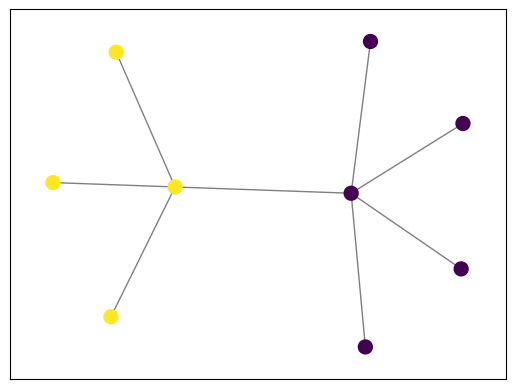

In [16]:
## Alternative: import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the graph (you can replace this with your own graph)
edge = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 7), (2, 8), (2, 9)]
G = nx.Graph()
G.add_edges_from(edge)

# Run the Louvain algorithm and get the partition
partition = community_louvain.best_partition(G)

# Visualization
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


In [8]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))
print("Number of Communities = ", len(communities))
print(communities)

Number of Communities =  6
[["boyle's law", 'ideal gas equation', 'isothermal process', 'pressure', 'quasi-static process', 'volume change', 'work', '∆v', '∆w'], ['carnot engine', 'equation (11.28)', 'ideal gas temperature', 'universal relation', 'universal temperature', 'universal thermodynamic temperature scale'], ['combustion reaction', 'free expansion', 'irreversible processes', 'reversible processes', 'second law of thermodynamics', 'spontaneous processes'], ['container', 'gas', 'internal energy', 'kinetic energy', 'molecule', 'molecules', 'potential energy', 'rotational motion', 'translational motion', 'vibrational motion'], ['heat absorbed'], ['heat released']]


### Create a dataframe for community colors

In [ ]:
%pip install seaborn

In [22]:
import seaborn as sns
import random
palette = "hls"

## Now add these colors to communities and make another dataframe
def colors2Community(communities) -> pd.DataFrame:
    ## Define a color palette
    p = sns.color_palette(palette, len(communities)).as_hex()
    random.shuffle(p)
    rows = []
    group = 0
    for community in communities:
        color = p.pop()
        group += 1
        for node in community:
            rows += [{"node": node, "color": color, "group": group}]
    df_colors = pd.DataFrame(rows)
    return df_colors


colors = colors2Community(communities)
colors

,node,color,group
0,boyle's law,#d3db57,1
1,ideal gas equation,#d3db57,1
2,isothermal process,#d3db57,1
3,pressure,#d3db57,1
4,quasi-static process,#d3db57,1
5,volume change,#d3db57,1
6,work,#d3db57,1
7,∆v,#d3db57,1
8,∆w,#d3db57,1
9,carnot engine,#57db5f,2


# Plotting the graph and saving it 

In [23]:
%pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 981.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
from pyvis.network import Network

In [25]:
for index, row in colors.iterrows():
    G.nodes[row['node']]['group'] = row['group']
    G.nodes[row['node']]['color'] = row['color']
    G.nodes[row['node']]['size'] = G.degree[row['node']]

In [ ]:
os.mkdir("./docs")

In [30]:

graph_output_directory = "/kaggle/working/index_thermodynamics.html"

net = Network(
    notebook=False,
    # bgcolor="#1a1a1a",
    cdn_resources="remote",
    height="900px",
    width="100%",
    select_menu=True,
    # font_color="#cccccc",
    filter_menu=False,
)

net.from_nx(G)
# net.repulsion(node_distance=150, spring_length=400)
net.force_atlas_2based(central_gravity=0.015, gravity=-31)
# net.barnes_hut(gravity=-18100, central_gravity=5.05, spring_length=380)
net.show_buttons(filter_=["physics"])

net.show(graph_output_directory, notebook=False)

/kaggle/working/index_thermodynamics.html
